# Task 2 Evaluation

This notebook contains the evaluation for Task 1 of the TREC Fair Ranking track.

In [1]:
DATA_MODE = 'eval'

In [2]:
import wptrec
wptrec.DATA_MODE = DATA_MODE

## Setup

We begin by loading necessary libraries:

In [3]:
from pathlib import Path
import pandas as pd
import numpy as np
import xarray as xr
from scipy.stats import bootstrap
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import binpickle

In [4]:
tbl_dir = Path('data/metric-tables/')

Set up progress bar and logging support:

In [5]:
from tqdm.auto import tqdm
tqdm.pandas(leave=False)

In [6]:
import sys, logging
logging.basicConfig(level=logging.INFO, stream=sys.stderr)
log = logging.getLogger('task2-eval')

Set up the RNG:

In [7]:
import seedbank
seedbank.initialize(20220101)
rng = seedbank.numpy_rng()

INFO:seedbank:initialized root seed SeedSequence(
    entropy=20220101,
)


Import metric code:

In [8]:
import wptrec.metrics as metrics
from wptrec.trecdata import scan_runs

And finally import the metric itself.  For Task 1, this uses:

* evaluation qrels
* evaluation intersectional targets
* all dimensions (with their page alignments)

In [9]:
from MetricInputs import qrels, dimensions

INFO:MetricInputs:reading data\metric-tables\page-sub-geo-align.parquet
INFO:MetricInputs:reading data\metric-tables\page-src-geo-align.parquet
INFO:MetricInputs:reading data\metric-tables\page-gender-align.parquet
INFO:MetricInputs:reading data\metric-tables\page-occ-align.parquet
INFO:MetricInputs:reading data\metric-tables\page-alpha-align.parquet
INFO:MetricInputs:reading data\metric-tables\page-age-align.parquet
INFO:MetricInputs:reading data\metric-tables\page-pop-align.parquet
INFO:MetricInputs:reading data\metric-tables\page-langs-align.parquet


In [10]:
%load_ext autoreload
%autoreload 2

In [11]:
import wptrec.metrics as metrics
from wptrec.trecdata import scan_runs

And finally import the metric itself:

In [12]:
target = xr.open_dataarray(tbl_dir / f'task2-{DATA_MODE}-int-targets.nc')

In [17]:
metric = metrics.EELMetric(qrels.set_index('topic_id'), dimensions, target)

## Importing Data



Let's load the runs now:

In [14]:
runs = pd.DataFrame.from_records(row for rows in scan_runs(2, 'runs/2022') for row in rows)
runs

INFO:wptrec.trecdata:scanning runs\2022\editors\0mt5_e.gz
INFO:wptrec.trecdata:scanning runs\2022\editors\0mt5_p_e.gz
INFO:wptrec.trecdata:scanning runs\2022\editors\ans_bm25_e.gz
INFO:wptrec.trecdata:scanning runs\2022\editors\bm25_p_e.gz
INFO:wptrec.trecdata:scanning runs\2022\editors\tmt5_e.gz
INFO:wptrec.trecdata:scanning runs\2022\editors\tmt5_p_e.gz
INFO:wptrec.trecdata:scanning runs\2022\editors\UogTRelvOnlyT2.gz
INFO:wptrec.trecdata:scanning runs\2022\editors\UoGTrMabSAED.gz
INFO:wptrec.trecdata:scanning runs\2022\editors\UoGTrMabSaNR.gz
INFO:wptrec.trecdata:scanning runs\2022\editors\UoGTrMabSaWR.gz
INFO:wptrec.trecdata:scanning runs\2022\editors\UoGTrMabWeSA.gz


,run_name,topic_id,seq_no,rank,page_id
0,0mt5_e,187,1,0,6386814
1,0mt5_e,187,2,0,6386814
2,0mt5_e,187,3,0,6386814
3,0mt5_e,187,4,0,6386814
4,0mt5_e,187,5,0,6386814
...,...,...,...,...,...
1879995,UoGTrMabWeSA,2872,100,15,7633197
1879996,UoGTrMabWeSA,2872,100,16,45660976
1879997,UoGTrMabWeSA,2872,100,17,53371247
1879998,UoGTrMabWeSA,2872,100,18,3957390


In [15]:
runs.head()

,run_name,topic_id,seq_no,rank,page_id
0,0mt5_e,187,1,0,6386814
1,0mt5_e,187,2,0,6386814
2,0mt5_e,187,3,0,6386814
3,0mt5_e,187,4,0,6386814
4,0mt5_e,187,5,0,6386814


## Computing Metrics

We are now ready to compute the metric for each (system,topic) pair.  Let's go!

In [33]:
rank_exp = runs.groupby(['run_name', 'topic_id']).progress_apply(metric)
# rank_exp = rank_awrf.unstack()
rank_exp

  0%|          | 0/517 [00:00<?, ?it/s]

EE-L          EE-D          EE-R
run_name topic_id                                          
0mt5_e   187       2.008808e-07  2.010981e-07  1.137204e-10
         270       1.085146e-07  1.087872e-07  1.547086e-10
         359       4.306499e-07  4.308415e-07  1.382234e-10
         365       1.772179e-07  1.776284e-07  2.282702e-10
         400       1.963890e-07  1.964442e-07  2.788367e-11
...                         ...           ...           ...
tmt5_p_e 2448      8.015489e-08  8.021901e-08  2.377903e-10
         2483      7.745578e-07  7.747622e-07  1.395746e-10
         2758      9.750875e-08  9.772520e-08  1.150679e-10
         2867      1.324810e-07  1.328479e-07  1.881705e-10
         2872      3.202079e-07  3.202146e-07  6.168503e-12

[517 rows x 3 columns]

Now let's average by runs:

In [34]:
run_scores = rank_exp.groupby('run_name').mean()
run_scores

,EE-L,EE-D,EE-R
run_name,,,
0mt5_e,2.669338e-07,2.682732e-07,1.472001e-09
0mt5_p_e,2.243727e-07,2.282545e-07,2.743218e-09
UoGTrMabSAED,8.816257e-07,8.867378e-07,3.358359e-09
UoGTrMabSaNR,1.392140e-06,1.393994e-06,1.729132e-09
UoGTrMabSaWR,8.514451e-07,8.553254e-07,2.742420e-09
UoGTrMabWeSA,8.517624e-07,8.558813e-07,2.861756e-09
UogTRelvOnlyT2,1.458895e-06,1.467089e-06,4.899363e-09
ans_bm25_e,6.210132e-07,6.228278e-07,1.709599e-09
bm25_p_e,2.579536e-07,2.613492e-07,2.500130e-09


And bootstrap some confidence intervals:

In [35]:
def boot_ci(col, name='EE-L'):
    res = bootstrap([col], statistic=np.mean, random_state=rng)
    return pd.Series({
        f'{name}.SE': res.standard_error,
        f'{name}.Lo': res.confidence_interval.low,
        f'{name}.Hi': res.confidence_interval.high,
        f'{name}.W': res.confidence_interval.high - res.confidence_interval.low
    })

In [36]:
run_score_ci = rank_exp.groupby('run_name')['EE-L'].apply(boot_ci).unstack()
run_score_ci

,EE-L.SE,EE-L.Lo,EE-L.Hi,EE-L.W
run_name,,,,
0mt5_e,2.052157e-08,2.334203e-07,3.151472e-07,8.172693e-08
0mt5_p_e,2.719558e-08,1.834765e-07,2.976696e-07,1.141930e-07
UoGTrMabSAED,1.241111e-07,7.055226e-07,1.250609e-06,5.450869e-07
UoGTrMabSaNR,1.994266e-07,1.122321e-06,2.010569e-06,8.882480e-07
UoGTrMabSaWR,1.151717e-07,6.817178e-07,1.169481e-06,4.877635e-07
UoGTrMabWeSA,1.393564e-07,6.613888e-07,1.296149e-06,6.347605e-07
UogTRelvOnlyT2,3.169987e-07,1.082730e-06,2.714518e-06,1.631788e-06
ans_bm25_e,2.549563e-07,3.372528e-07,1.792222e-06,1.454969e-06
bm25_p_e,3.525732e-08,2.029881e-07,3.475143e-07,1.445262e-07


In [37]:
run_score_full = run_scores.join(run_score_ci)
run_score_full.sort_values('EE-L', ascending=False, inplace=True)
run_score_full

,EE-L,EE-D,EE-R,EE-L.SE,EE-L.Lo,EE-L.Hi,EE-L.W
run_name,,,,,,,
UogTRelvOnlyT2,1.458895e-06,1.467089e-06,4.899363e-09,3.169987e-07,1.082730e-06,2.714518e-06,1.631788e-06
UoGTrMabSaNR,1.392140e-06,1.393994e-06,1.729132e-09,1.994266e-07,1.122321e-06,2.010569e-06,8.882480e-07
UoGTrMabSAED,8.816257e-07,8.867378e-07,3.358359e-09,1.241111e-07,7.055226e-07,1.250609e-06,5.450869e-07
UoGTrMabWeSA,8.517624e-07,8.558813e-07,2.861756e-09,1.393564e-07,6.613888e-07,1.296149e-06,6.347605e-07
UoGTrMabSaWR,8.514451e-07,8.553254e-07,2.742420e-09,1.151717e-07,6.817178e-07,1.169481e-06,4.877635e-07
ans_bm25_e,6.210132e-07,6.228278e-07,1.709599e-09,2.549563e-07,3.372528e-07,1.792222e-06,1.454969e-06
0mt5_e,2.669338e-07,2.682732e-07,1.472001e-09,2.052157e-08,2.334203e-07,3.151472e-07,8.172693e-08
bm25_p_e,2.579536e-07,2.613492e-07,2.500130e-09,3.525732e-08,2.029881e-07,3.475143e-07,1.445262e-07
0mt5_p_e,2.243727e-07,2.282545e-07,2.743218e-09,2.719558e-08,1.834765e-07,2.976696e-07,1.141930e-07


## Per-Topic Stats

We need to return per-topic stats to each participant, at least for the score.

In [38]:
topic_stats = rank_exp.groupby('topic_id').agg(['mean', 'median', 'min', 'max'])
topic_stats

EE-L                                            \
                  mean        median           min           max   
topic_id                                                           
187       4.027423e-07  2.008808e-07  7.363171e-08  1.148012e-06   
270       4.760671e-07  3.022737e-07  1.085146e-07  1.616116e-06   
359       4.389307e-07  3.990673e-07  1.400138e-07  1.032055e-06   
365       3.283279e-07  1.772179e-07  1.155891e-07  8.254423e-07   
400       1.585473e-06  2.188442e-07  1.526429e-07  4.976649e-06   
404       1.703499e-06  2.247651e-07  7.271896e-14  4.511778e-06   
480       4.390561e-07  3.337837e-07  4.312155e-08  1.182038e-06   
517       5.601782e-07  4.522605e-07  1.179611e-07  1.122743e-06   
568       6.445953e-07  2.021915e-07  1.099856e-07  2.402476e-06   
596       6.069159e-07  5.361030e-07  1.625580e-07  1.000491e-06   
715       3.272378e-07  1.951873e-07  1.168561e-07  8.663455e-07   
807       4.716589e-07  2.686399e-07  1.392837e-07  1.602194e-06   
834       4.024170e-07  3.747386e-07  1.792973e-07  7.189292e-07   
881       3.474223e-07  2.323759e-07  1.723090e-07  8.337136e-07   
883       3.224473e-07  1.499645e-07  9.154208e-08  7.122607e-07   
949       3.181534e-07  1.997850e-07  1.140590e-07  6.897380e-07   
951       1.711040e-06  1.007690e-06  3.929124e-07  8.695455e-06   
955       3.826884e-07  2.680015e-07  1.427026e-07  1.058279e-06   
995       5.870383e-07  3.170129e-07  1.713622e-07  1.916517e-06   
1018      4.572748e-07  1.655114e-07  3.963174e-08  1.747079e-06   
1180      6.012271e-07  2.585387e-07  1.183325e-07  1.900230e-06   
1233      3.180384e-07  2.956114e-07  1.422134e-07  6.366161e-07   
1328      6.198318e-07  2.424092e-07  6.013630e-08  1.608693e-06   
1406      7.413211e-07  6.580505e-07  1.089217e-07  2.155281e-06   
1417      5.249093e-07  5.523858e-07  1.466662e-07  1.194777e-06   
1448      3.815859e-07  2.944469e-07  7.790395e-08  8.065180e-07   
1479      4.194426e-07  2.907037e-07  1.020728e-07  1.065884e-06   
1548      4.662257e-07  3.955077e-07  1.301894e-07  1.018841e-06   
1558      7.076794e-07  4.390278e-07  2.125311e-07  1.408983e-06   
1647      5.921483e-07  2.372080e-07  1.263999e-07  1.474614e-06   
1806      5.092016e-07  2.283661e-07  6.784599e-08  2.063863e-06   
1821      3.270946e-06  1.331497e-06  1.183848e-07  1.529291e-05   
1877      2.717125e-07  1.966945e-07  1.049553e-07  8.408557e-07   
1884      5.405809e-07  4.527797e-07  1.549650e-07  1.273585e-06   
1890      4.757834e-07  2.179866e-07  1.399375e-07  1.293181e-06   
2000      5.691327e-07  4.793545e-07  1.943042e-07  1.313041e-06   
2028      4.854245e-07  3.007538e-07  1.202685e-07  1.161324e-06   
2106      4.410706e-07  2.066111e-07  8.697724e-08  1.860595e-06   
2153      5.291417e-07  2.981244e-07  1.294492e-07  1.458933e-06   
2160      8.325383e-07  2.428921e-07  1.644152e-07  3.776652e-06   
2229      3.106761e-07  3.360841e-07  1.034237e-07  5.121759e-07   
2244      4.296862e-07  2.229142e-07  2.158442e-11  1.187008e-06   
2448      5.318852e-07  2.991786e-07  8.015489e-08  1.228626e-06   
2483      7.131035e-07  6.177457e-07  7.471750e-11  1.803764e-06   
2758      5.650378e-07  2.968386e-07  9.750875e-08  1.925211e-06   
2867      8.546224e-07  3.208801e-07  1.270074e-07  2.301909e-06   
2872      1.533333e-06  4.524165e-07  1.293092e-07  1.197821e-05   

                  EE-D                                            \
                  mean        median           min           max   
topic_id                                                           
187       4.029641e-07  2.010981e-07  7.371646e-08  1.148199e-06   
270       4.777506e-07  3.022561e-07  1.087872e-07  1.616436e-06   
359       4.397905e-07  4.001581e-07  1.411606e-07  1.032386e-06   
365       3.287299e-07  1.776284e-07  1.162162e-07  8.256404e-07   
400       1.585526e-06  2.189153e-07  1.527080e-07  4.976698e-06   
404       1.703502e-06  2.247686e-07  0.000000e+00  4.511778e-06   
480  

Make final score analysis:

In [39]:
topic_range = topic_stats.loc[:, 'EE-L']
topic_range = topic_range.drop(columns=['mean'])
topic_range

,median,min,max
topic_id,,,
187,2.008808e-07,7.363171e-08,1.148012e-06
270,3.022737e-07,1.085146e-07,1.616116e-06
359,3.990673e-07,1.400138e-07,1.032055e-06
365,1.772179e-07,1.155891e-07,8.254423e-07
400,2.188442e-07,1.526429e-07,4.976649e-06
404,2.247651e-07,7.271896e-14,4.511778e-06
480,3.337837e-07,4.312155e-08,1.182038e-06
517,4.522605e-07,1.179611e-07,1.122743e-06
568,2.021915e-07,1.099856e-07,2.402476e-06


And now we combine scores with these results to return to participants.

In [49]:
ret_dir = Path('results') / 'editors'
ret_dir.mkdir(exist_ok=True)
for system, s_runs in rank_exp.groupby('run_name'):
    aug = s_runs.join(topic_range).reset_index().drop(columns=['run_name'])
    fn = ret_dir / f'{system}.tsv'
    log.info('writing %s', fn)
    aug.to_csv(fn, sep='\t', index=False)

INFO:task2-eval:writing results\editors\0mt5_e.tsv
INFO:task2-eval:writing results\editors\0mt5_p_e.tsv
INFO:task2-eval:writing results\editors\UoGTrMabSAED.tsv
INFO:task2-eval:writing results\editors\UoGTrMabSaNR.tsv
INFO:task2-eval:writing results\editors\UoGTrMabSaWR.tsv
INFO:task2-eval:writing results\editors\UoGTrMabWeSA.tsv
INFO:task2-eval:writing results\editors\UogTRelvOnlyT2.tsv
INFO:task2-eval:writing results\editors\ans_bm25_e.tsv
INFO:task2-eval:writing results\editors\bm25_p_e.tsv
INFO:task2-eval:writing results\editors\tmt5_e.tsv
INFO:task2-eval:writing results\editors\tmt5_p_e.tsv


## Charts and Relationships

Now let's look at some overall distributions, etc.

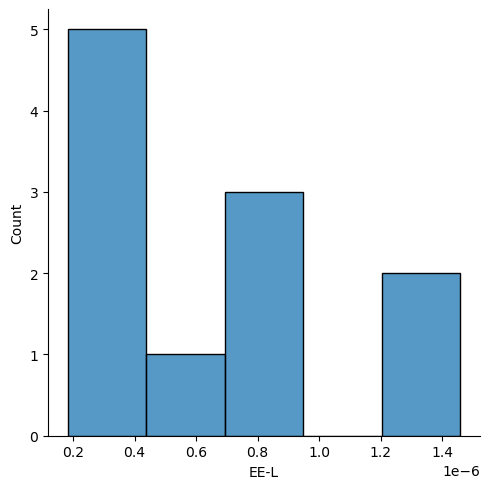

In [41]:
sns.displot(x='EE-L', data=run_scores)

<AxesSubplot:xlabel='EE-D', ylabel='EE-R'>

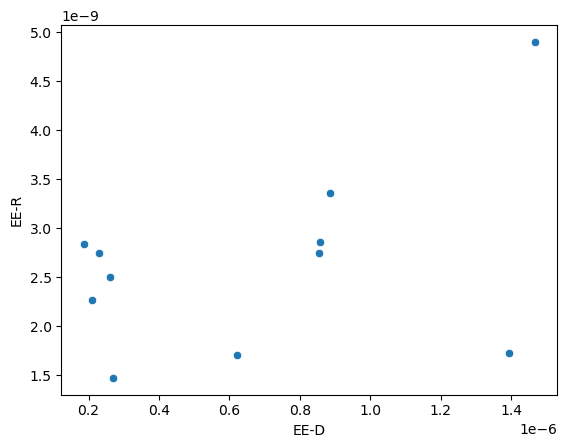

In [42]:
sns.scatterplot(x='EE-D', y='EE-R', data=run_scores)

## Further Analysis

That's how we capture the first-order analysis. Now let's look at things one dimension at a time.

### Gender

Let's just look at gender.

In [43]:
gender_tgt = pd.read_parquet(tbl_dir / f'task2-{DATA_MODE}-gender-target.parquet')
gender_tgt.head()

,@UNKNOWN,female,male,NB
topic_id,,,,
187,0.889284,0.033562,0.076585,0.000568
270,0.367175,0.258629,0.370951,0.003245
359,0.333492,0.172195,0.490980,0.003333
365,0.421035,0.185453,0.390618,0.002895
400,0.011616,0.406848,0.576285,0.005251


In [44]:
gender_tgt = xr.DataArray(gender_tgt.values, coords=[gender_tgt.index, gender_tgt.columns], dims=['topic_id', 'gender'])
gender_tgt

<xarray.DataArray (topic_id: 50, gender: 4)>
array([[8.89284066e-01, 3.35622972e-02, 7.65852665e-02, 5.68370221e-04],
       [3.67175391e-01, 2.58628681e-01, 3.70951122e-01, 3.24480557e-03],
       [3.33491930e-01, 1.72195254e-01, 4.90980275e-01, 3.33254035e-03],
       [4.21034859e-01, 1.85452573e-01, 3.90617742e-01, 2.89482570e-03],
       [1.16164305e-02, 4.06847864e-01, 5.76285100e-01, 5.25060533e-03],
       [2.92317125e-03, 3.13129724e-01, 6.78943054e-01, 5.00405120e-03],
       [7.87304447e-01, 8.26068357e-02, 1.29025239e-01, 1.06347776e-03],
       [1.28564418e-01, 2.65230463e-01, 6.01726811e-01, 4.47830827e-03],
       [5.19715412e-01, 1.35951720e-01, 3.41931446e-01, 2.40142294e-03],
       [7.38065736e-01, 9.44266909e-02, 1.66153048e-01, 1.35452510e-03],
       [9.93131431e-01, 1.96776414e-03, 4.86646196e-03, 3.43428447e-05],
       [4.70907702e-01, 2.74761660e-01, 2.51547485e-01, 2.78315306e-03],
       [6.46888773e-01, 1.88853907e-01, 1.62303802e-01, 1.95351854e-03],
       [9.96417004e-01, 1.26745963e-03, 2.29762161e-03, 1.79149811e-05],
       [7.26686151e-01, 8.68433931e-02, 1.84877745e-01, 1.59271097e-03],
       [4.13267622e-01, 4.33392702e-01, 1.49440180e-01, 3.89949661e-03],
       [9.97325828e-01, 1.41054983e-03, 1.25025175e-03, 1.33708622e-05],
       [9.99427961e-01, 2.38483905e-04, 3.30694827e-04, 2.86019463e-06],
       [9.96433372e-01, 1.18690473e-03, 2.36189057e-03, 1.78331422e-05],
       [3.21922744e-01, 1.85338159e-01, 4.89345638e-01, 3.39345920e-03],
...
       [8.19836299e-01, 6.63546390e-02, 1.12886143e-01, 9.22919303e-04],
       [6.84240406e-01, 8.39632782e-02, 2.30195804e-01, 1.60051148e-03],
       [6.94764022e-01, 8.47861695e-02, 2.18913422e-01, 1.53638667e-03],
       [5.60861965e-01, 1.72454141e-01, 2.64317273e-01, 2.36662207e-03],
       [9.83557840e-01, 7.86782393e-03, 8.49212490e-03, 8.22107981e-05],
       [1.26360466e-01, 3.29443903e-01, 5.39805094e-01, 4.39053637e-03],
       [3.91852779e-01, 2.81377881e-01, 3.23728604e-01, 3.04073611e-03],
       [7.50845345e-01, 8.78520965e-02, 1.60056785e-01, 1.24577327e-03],
       [4.09729417e-01, 2.45312411e-01, 3.41752055e-01, 3.20611734e-03],
       [6.54433814e-01, 1.75414910e-01, 1.68121254e-01, 2.03002233e-03],
       [9.99754073e-01, 7.47261677e-05, 1.69970767e-04, 1.22963284e-06],
       [4.92656371e-01, 1.66737776e-01, 3.38069135e-01, 2.53671815e-03],
       [9.98014492e-01, 7.19309018e-04, 1.25627169e-03, 9.92754127e-06],
       [6.19215269e-01, 1.32001089e-01, 2.46796355e-01, 1.98728675e-03],
       [9.98791894e-01, 4.87067949e-04, 7.14997975e-04, 6.04053228e-06],
       [6.52082075e-01, 1.53802137e-01, 1.92352637e-01, 1.76315047e-03],
       [9.99881713e-01, 2.92761225e-05, 8.84198042e-05, 5.91436818e-07],
       [4.18588506e-01, 2.21890037e-01, 3.56490218e-01, 3.03123913e-03],
       [1.76340535e-01, 6.14506988e-01, 2.04662739e-01, 4.48973827e-03],
       [3.35561589e-01, 4.92585651e-01, 1.68466051e-01, 3.38670968e-03]])
Coordinates:
  * topic_id  (topic_id) int64 187 270 359 365 400 ... 2448 2483 2758 2867 2872
  * gender    (gender) object '@UNKNOWN' 'female' 'male' 'NB'

In [45]:
gender_metric = metrics.EELMetric(qrels.set_index('topic_id'), dimensions[2:3], gender_tgt)

In [47]:
rank_gender = runs.groupby(['run_name', 'topic_id']).progress_apply(gender_metric)
rank_gender

  0%|          | 0/517 [00:00<?, ?it/s]

TypeError: __call__() missing 1 required keyword-only argument: 'normalize'

And aggregate:

In [49]:
rank_gender.groupby('run_name').mean()

,EE-L,EE-D,EE-R
run_name,,,
task2-prec50.tsv,0.094151,-0.105541,0.511443


### Subject Geography

And now subject geography.

In [ ]:
sub_geo_tgt = pd.read_parquet(tbl_dir / f'task2-{DATA_MODE}-sub-geo-target.parquet')
sub_geo_tgt.head()

In [ ]:
sub_geo_tgt = xr.DataArray(sub_geo_tgt.values, coords=[sub_geo_tgt.index, sub_geo_tgt.columns], dims=['topic_id', 'sub-geo'])
sub_geo_tgt

In [ ]:
sub_geo_metric = metrics.EELMetric(qrels.set_index('topic_id'), [d for d in dimensions if d.name == 'sub-geo'], sub_geo_tgt)

In [ ]:
rank_sub_geo = runs.groupby(['run_name', 'topic_id']).progress_apply(sub_geo_metric)
rank_sub_geo

And aggregate:

In [ ]:
rank_sub_geo.groupby('run_name').mean()